In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
from tqdm import tqdm
from matplotlib import pyplot as plt
import eda
from python_speech_features import mfcc, logfbank
from scipy.io import wavfile
import librosa


In [31]:
df = pd.read_csv(os.path.join('data', 'instruments.csv'))
print(df)
print(df.head())

            fname      label
0    5388d14d.wav  Saxophone
1    c685f05f.wav  Saxophone
2    36d20ab5.wav  Saxophone
3    d6665734.wav  Saxophone
4    7352e28f.wav  Saxophone
..            ...        ...
295  3c713bcf.wav   Clarinet
296  2fc00271.wav   Clarinet
297  b0c06255.wav   Clarinet
298  71c6451f.wav   Clarinet
299  5de123c3.wav   Clarinet

[300 rows x 2 columns]
          fname      label
0  5388d14d.wav  Saxophone
1  c685f05f.wav  Saxophone
2  36d20ab5.wav  Saxophone
3  d6665734.wav  Saxophone
4  7352e28f.wav  Saxophone


In [32]:
df.set_index('fname', inplace=True) # Set our index to be the fname collumn

In [33]:
print(df)

                  label
fname                  
5388d14d.wav  Saxophone
c685f05f.wav  Saxophone
36d20ab5.wav  Saxophone
d6665734.wav  Saxophone
7352e28f.wav  Saxophone
...                 ...
3c713bcf.wav   Clarinet
2fc00271.wav   Clarinet
b0c06255.wav   Clarinet
71c6451f.wav   Clarinet
5de123c3.wav   Clarinet

[300 rows x 1 columns]


In [34]:
# Read in the rate and signal for each of our wavfiles
# and add their ratio to our df as a length collumn/feature
for f in df.index:
    rate, signal = wavfile.read('data/wavfiles/'+f)
    df.at[f,'length'] = signal.shape[0] / rate

In [35]:
print(df)

                  label  length
fname                          
5388d14d.wav  Saxophone    4.14
c685f05f.wav  Saxophone    1.54
36d20ab5.wav  Saxophone    4.90
d6665734.wav  Saxophone   10.50
7352e28f.wav  Saxophone    6.24
...                 ...     ...
3c713bcf.wav   Clarinet    6.14
2fc00271.wav   Clarinet    4.20
b0c06255.wav   Clarinet    4.08
71c6451f.wav   Clarinet    3.56
5de123c3.wav   Clarinet    3.34

[300 rows x 2 columns]


In [36]:
# Create a class list and class distribution
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

In [37]:
print(class_dist)

label
Acoustic_guitar     6.948667
Bass_drum           1.937333
Cello               5.000667
Clarinet            6.596000
Double_bass         3.206000
Flute               8.054667
Hi-hat              3.357333
Saxophone           7.124000
Snare_drum          3.987333
Violin_or_fiddle    4.530000
Name: length, dtype: float64


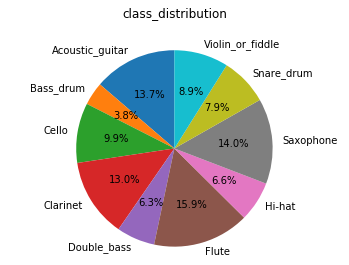

In [38]:
fig, ax = plt.subplots()
ax.set_title ('class_distribution', y = 1.08) # 1.08 to move title up slightly

# Setup pie chart with autopct to round off floats
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
      shadow=False, startangle=90)

ax.axis('equal') # Make the pie chart a circle rather than elipse

plt.show()
df.reset_index(inplace=True)



Here we have an idea of how the classes are distribution. We can see the bass drum constitues a disproportionately small amount of the data. In order to even out the data we would have to throw out a lot of data which is not ideal.

In [39]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

In [40]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d = 1/rate) # d is our spacing between signal (time that passes between each sample)
    Y = abs(np.fft.rfft(y) / n) # Find the magnitude of our fft, scaled by length of signal
    return(Y, freq)

In [41]:
# Grab a sample for each class then calculate its signal, fft, fbank, and mfcc
for c in classes:
    wav_file = df[df.label==c].iloc[0,0] # Use iloc to select by position
    signal, rate = librosa.load('data/wavfiles/'+wav_file, sr=44100) # Read in signal and rate with sr coming from scipy.io
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T # Get nfft with sr / 40
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfft = 1103).T
    mfccs[c] = mel

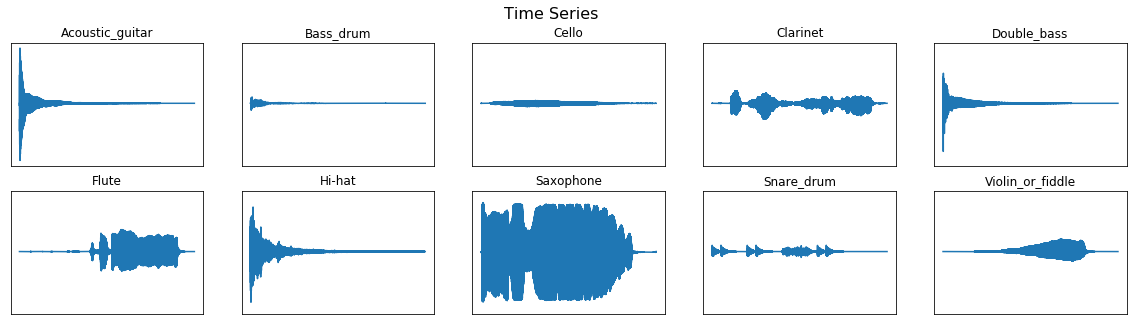

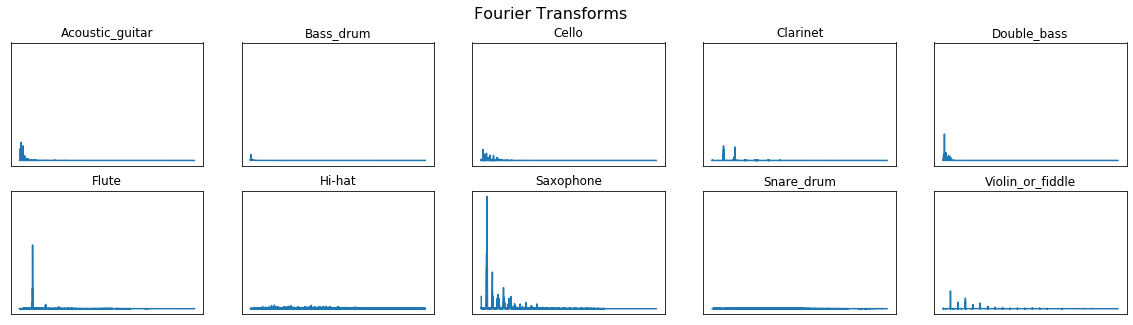

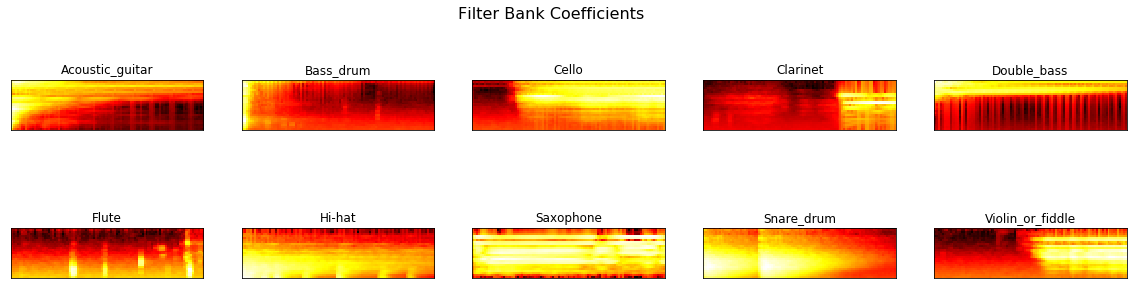

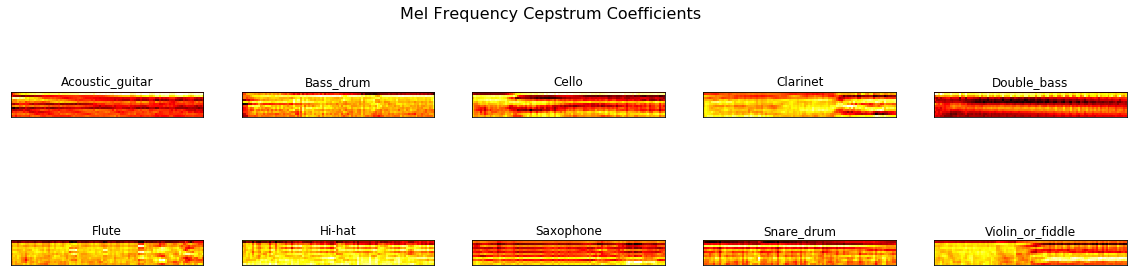

In [42]:
eda.plot_signals(signals)
plt.show()

eda.plot_fft(fft)
plt.show()

eda.plot_fbank(fbank)
plt.show()

eda.plot_mfccs(mfccs)
plt.show()

Looking at our time series, we can see a lot of empty space which we can remove later. Looking at Filter Banks and MFCCs we can start to tell each apart. We now create a function to find the envelope of a wave, an example of which we see here. This can help by ignoring, for the most part, portions where the values fall to zero.

![](figures/signal_envelopes.png)

In [43]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs) # Convert to series and apply absolute value to deal with negative signal portions
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean() # Get rolling average
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [44]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

In [45]:
# Grab a sample for each class then calculate its signal, fft, fbank, and mfcc this time with the mask
for c in classes:
    wav_file = df[df.label==c].iloc[0,0] # Use iloc to select by position
    signal, rate = librosa.load('data/wavfiles/'+wav_file, sr=44100) # Read in signal and rate with sr coming from scipy.io
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T # Get nfft with sr / 40
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfft = 1103).T
    mfccs[c] = mel

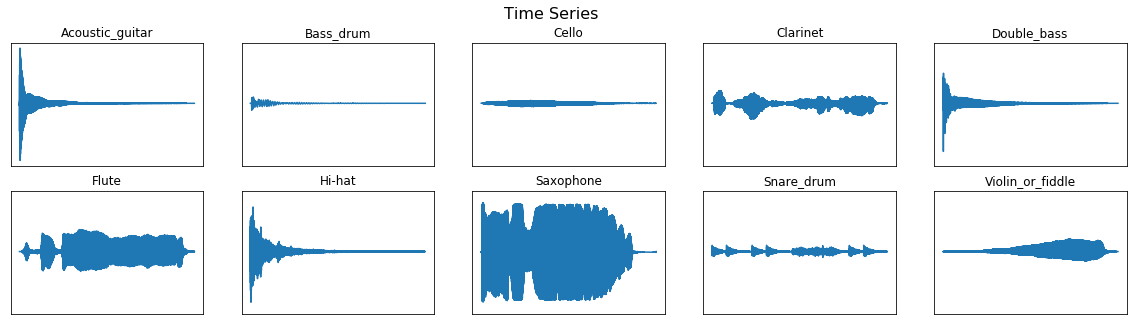

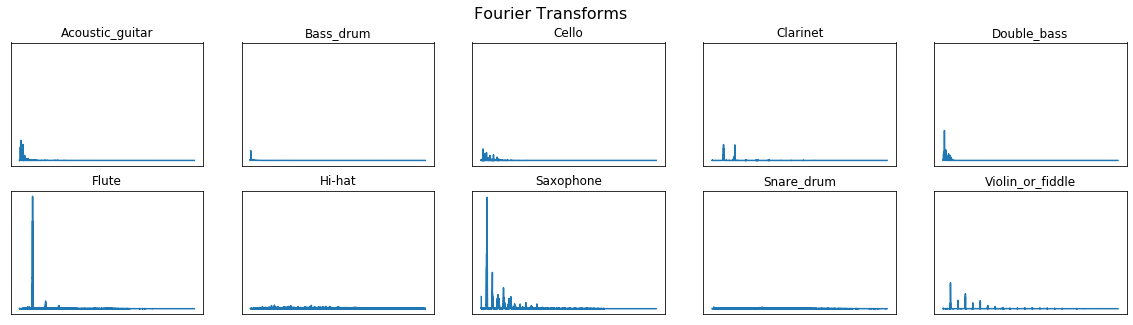

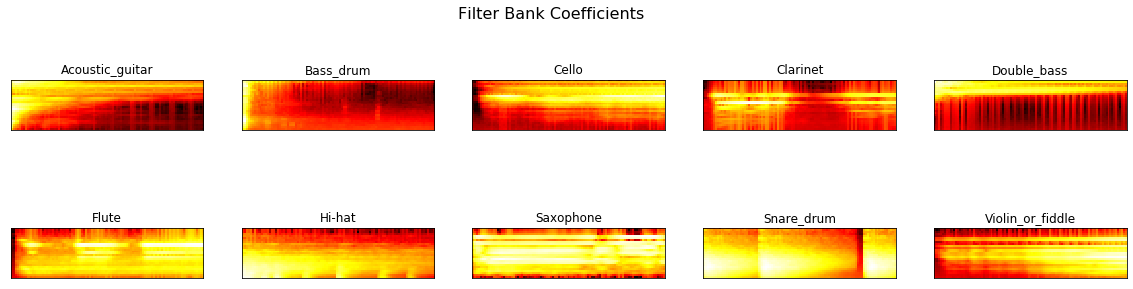

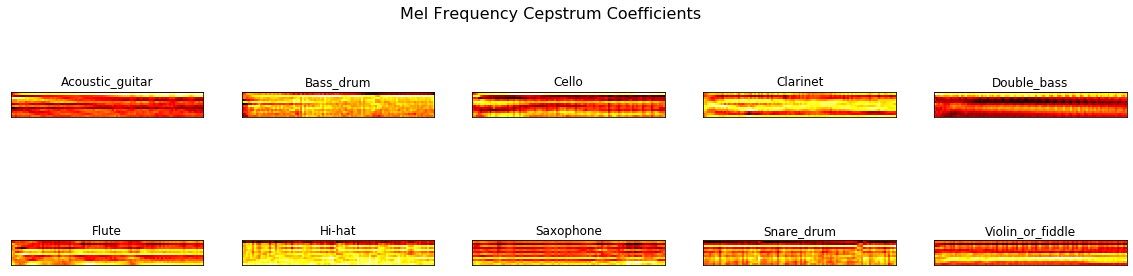

In [46]:
eda.plot_signals(signals)
plt.show()

eda.plot_fft(fft)
plt.show()

eda.plot_fbank(fbank)
plt.show()

eda.plot_mfccs(mfccs)
plt.show()

Now we can see a lot of the dead space, such as the gaps in flute, has been removed. We can now apply this concept to all of our data and save it in our 'clean' folder.

In [47]:
if len(os.listdir('data/clean')) == 0:
    for f in tqdm(df.fname):
        signal, rate = librosa.load('data/wavfiles/'+f, sr=16000) # Load in signal and rate
        mask = envelope(signal, rate, 0.0005) # Create envelope
        wavfile.write(filename='data/clean/'+f, rate=rate, data=signal[mask]) # Write in wav file with signal indexed by mask

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [02:10<00:00,  2.30it/s]
